## Pacotes utilizados

In [135]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.11


In [1]:
# Gerais para manipulação de Dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Pré processamento e engenharia de atributos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn import svm
from sklearn.neural_network import MLPRegressor
import sklearn
import joblib
import pickle
import time

In [140]:
# Versões dos pacotes usados neste jupyter notebook
# !pip install watermark
%reload_ext watermark
%watermark -a "Mentoria DSA 2021 - Turma 43" --iversions

Author: Mentoria DSA 2021 - Turma 43

pandas    : 1.1.5
matplotlib: 3.2.2
seaborn   : 0.11.1
numpy     : 1.19.5
google    : 2.0.3
IPython   : 5.5.0
sklearn   : 0.0
joblib    : 1.0.1



## Carregamento dos dados

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df_original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/dfPrecoMensal_AnoMes.csv", sep = ',', decimal='.', error_bad_lines=False)
df_original_v2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/dfPrecoMensal_AnoMes_remocao_std.csv", sep = ',', decimal='.', error_bad_lines=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582482 entries, 0 to 1582481
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ano_mes          1582482 non-null  object 
 1   contratacao      1582482 non-null  object 
 2   segmentacao      1582482 non-null  object 
 3   in_odonto        1582482 non-null  int64  
 4   in_obstetricia   1582482 non-null  int64  
 5   tipo             1582482 non-null  object 
 6   abrangencia      1582482 non-null  object 
 7   fator            1582482 non-null  object 
 8   acomodacao       1582482 non-null  object 
 9   internacao       1582482 non-null  object 
 10  cd_faixa_etaria  1582482 non-null  int64  
 11  nm_regiao        1582482 non-null  object 
 12  mensalidade      1582482 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 157.0+ MB


#### Variáveis ``explanatórias``

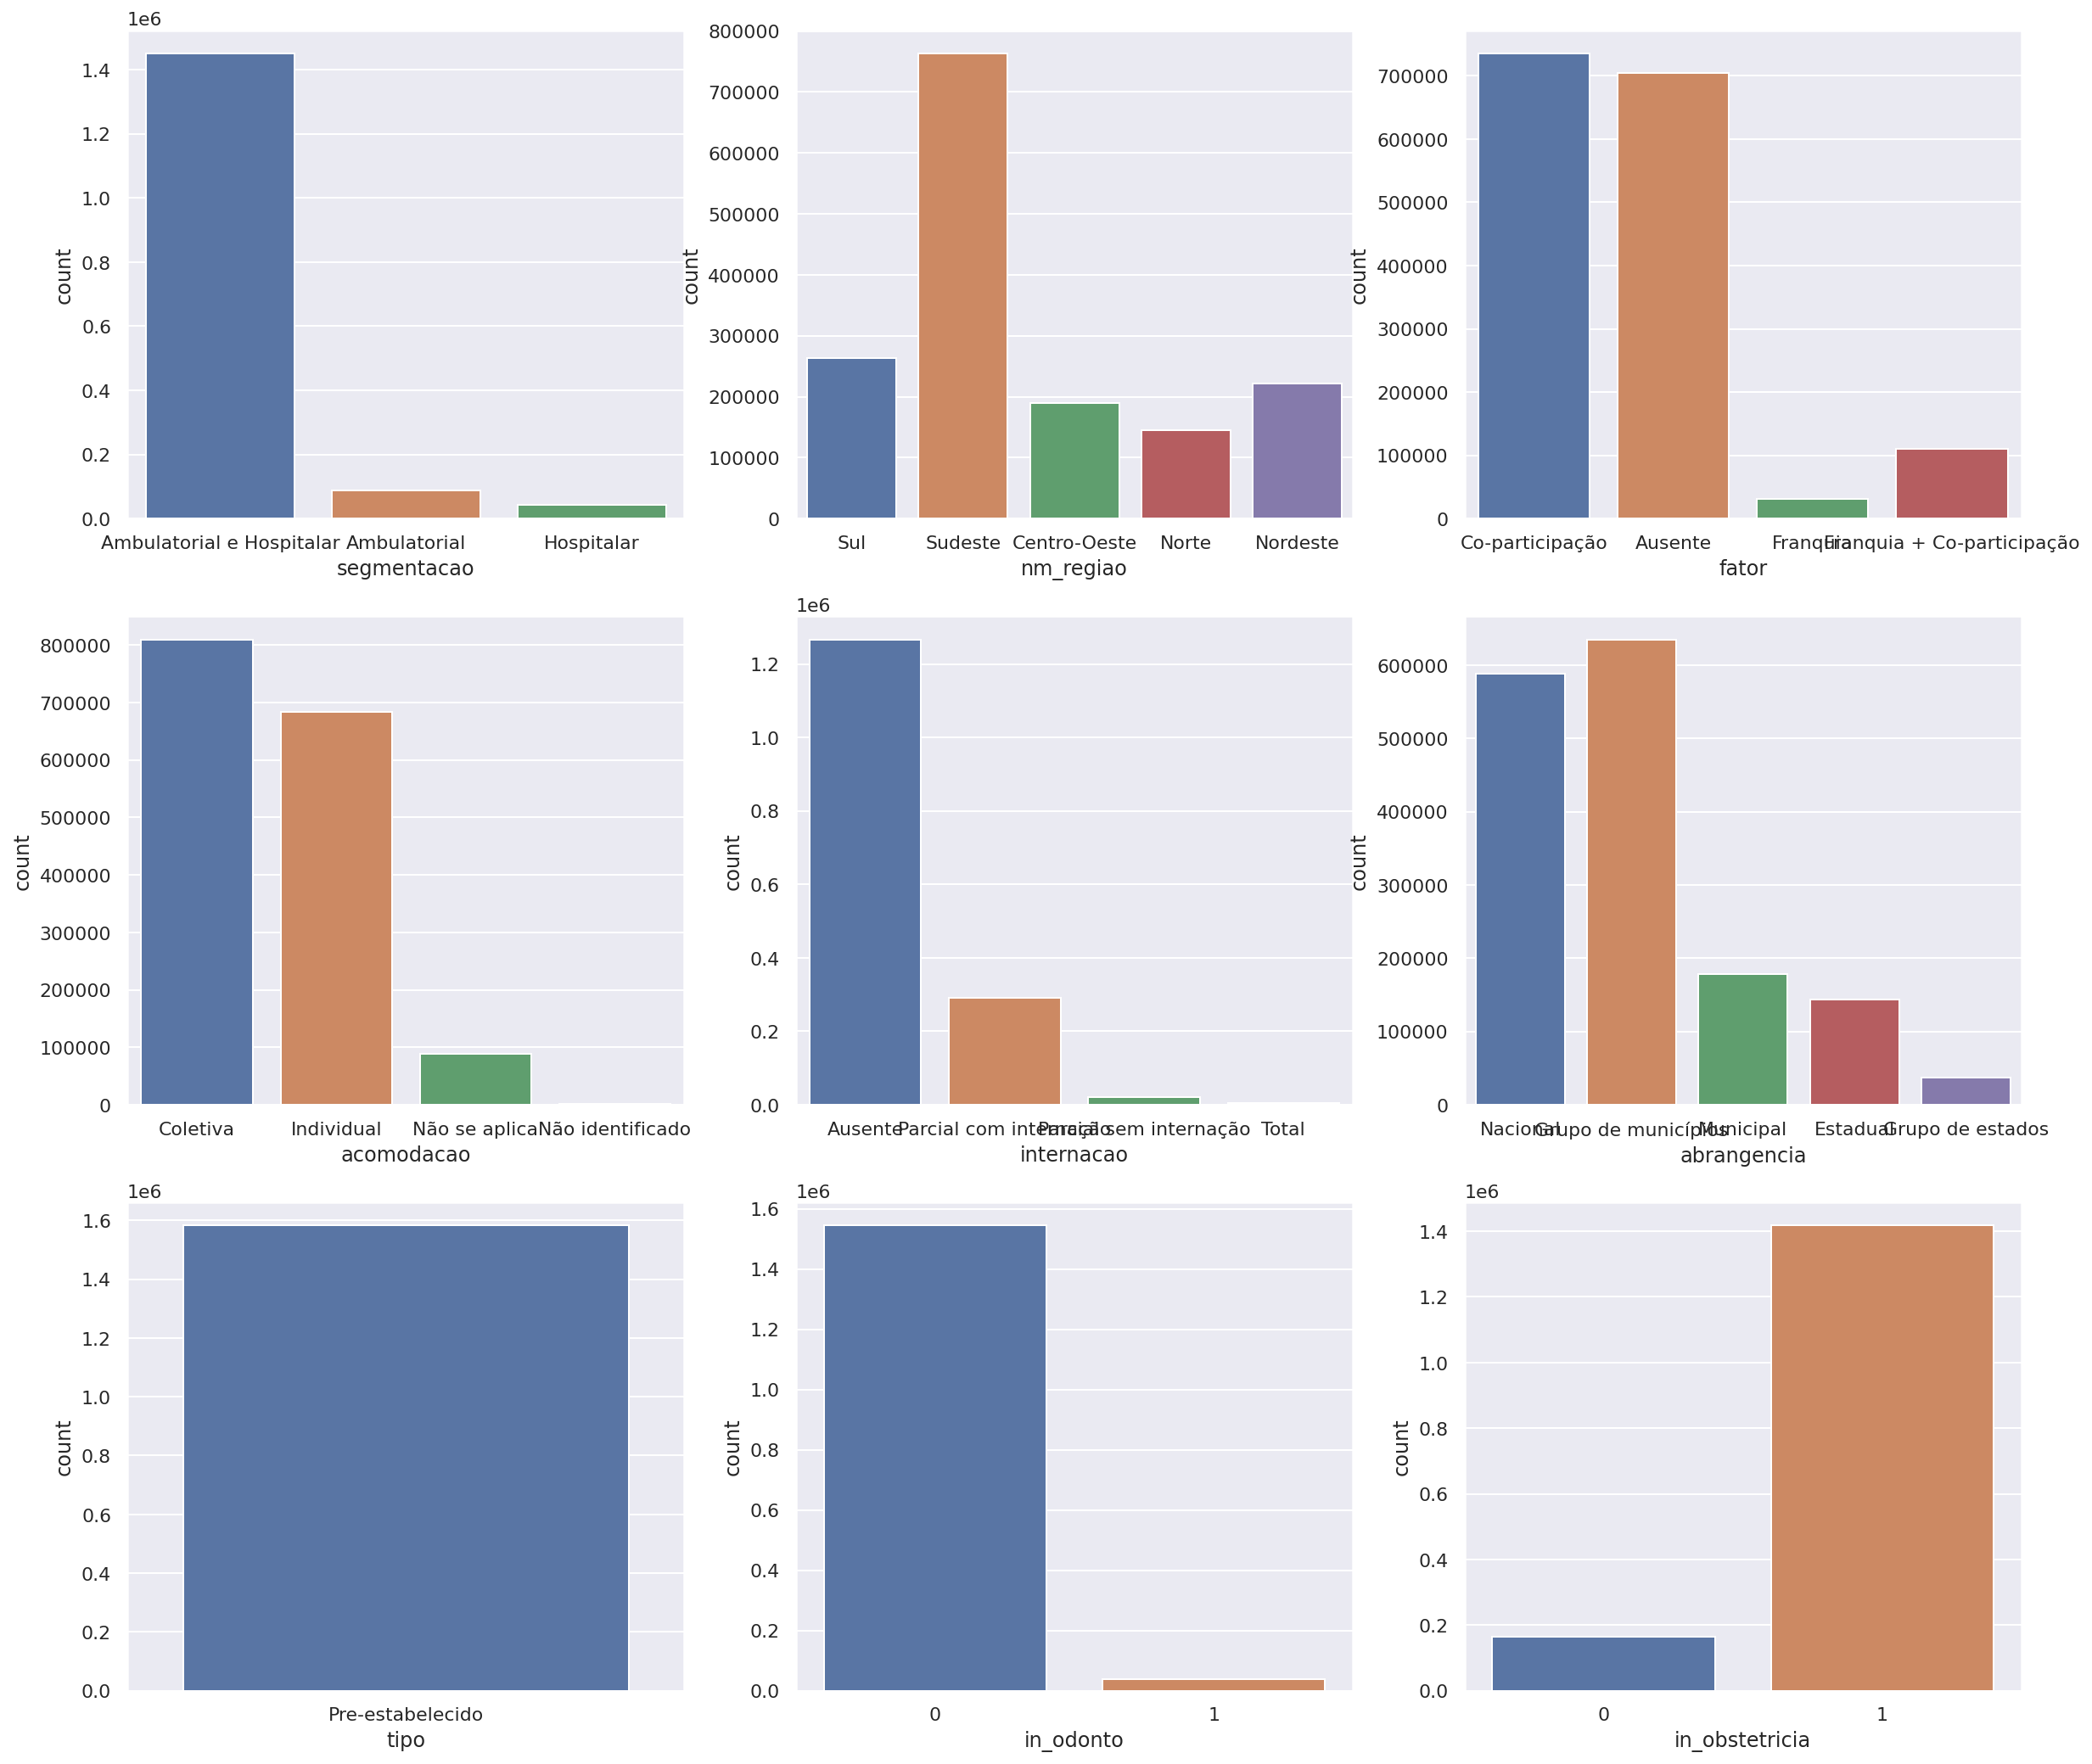

In [6]:
sns.set()
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

_, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))

sns.countplot(x="segmentacao", data=df_original, ax=axes[0][0])
sns.countplot(x="nm_regiao", data=df_original, ax=axes[0][1])
sns.countplot(x="fator", data=df_original, ax=axes[0][2]);
sns.countplot(x="acomodacao", data=df_original, ax=axes[1][0]);
sns.countplot(x="internacao", data=df_original, ax=axes[1][1]);
sns.countplot(x="abrangencia", data=df_original, ax=axes[1][2]);
sns.countplot(x="tipo", data=df_original, ax=axes[2][0]);
sns.countplot(x="in_odonto", data=df_original, ax=axes[2][1]);
sns.countplot(x="in_obstetricia", data=df_original, ax=axes[2][2]);

#### Variável ``target``

Text(0.5, 1.0, 'Boxplot - Mensalidade')

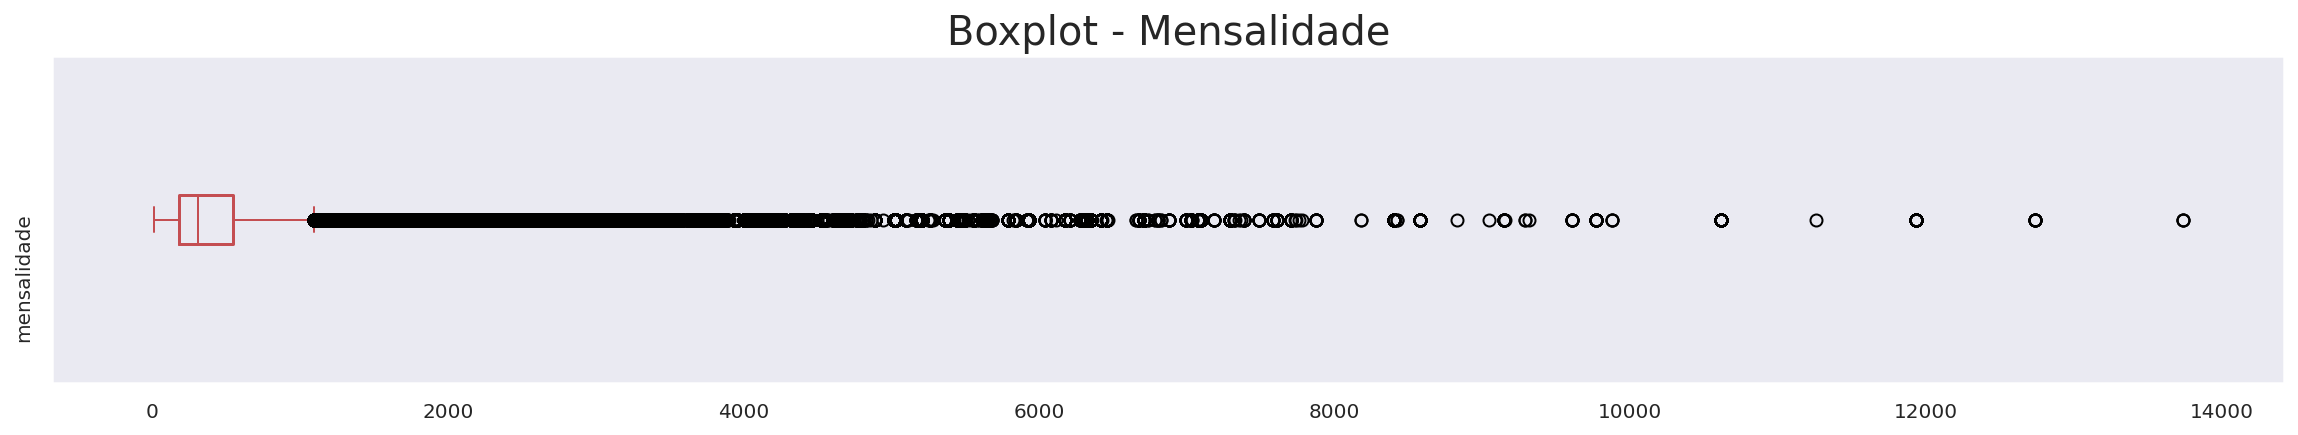

In [7]:
boxprops = dict(linestyle='-', linewidth=1.5, color = 'r')
df_original.boxplot(column=['mensalidade'], 
                vert=False, 
                grid=False,
                showfliers=True, 
                rot=90, 
                fontsize=10, 
                figsize=(20,3),
                color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                boxprops=boxprops).set_title("Boxplot - Mensalidade", fontsize=20)

## Pré processamento dos dados

In [4]:
# Conversão atributos em dados categóricos, com exceção do valor do plano
for c in df_original.columns:
  if df_original[c].dtype != "float64":
    df_original[c] = df_original[c].astype("category")

In [5]:
# Trabalhando com cópias do DataFrame original
df_copia = df_original.copy()

In [6]:
# A categoria "tipo" apresenta apenas um valor, vamos retirar do contexto de análise
del df_copia["tipo"]
# A remoção da categoria "contratacao" apresentou resultados melhores nos treinammentos
del df_copia["contratacao"]

In [8]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582482 entries, 0 to 1582481
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   ano_mes          1582482 non-null  category
 1   segmentacao      1582482 non-null  category
 2   in_odonto        1582482 non-null  category
 3   in_obstetricia   1582482 non-null  category
 4   abrangencia      1582482 non-null  category
 5   fator            1582482 non-null  category
 6   acomodacao       1582482 non-null  category
 7   internacao       1582482 non-null  category
 8   cd_faixa_etaria  1582482 non-null  category
 9   nm_regiao        1582482 non-null  category
 10  mensalidade      1582482 non-null  float64 
dtypes: category(10), float64(1)
memory usage: 27.2 MB


#### Remoção dos valores _outliers_ da variável ``target`` com base no desvio padrão

In [ ]:
start = time.time()

def f(args):
    import numpy as np
    import pandas as pd
    import operator
    import time
    
    (x, atributos, visited, target) = args
    
    # Para cada combinação existente nos dados, exclui registros com mensalide < média - desvio padrão ou com mensalidade > média + desvio padrão
    # visited: armazena as combinações encontradas e suas frequência
    # tempo de execução: +-47min
    def remStd(df, attributes, int_attributes = ['in_obstetricia', 'in_odonto', 'cd_faixa_etaria'], visited = {}):
        dd = pd.DataFrame()
        start = time.time()
        count = 0
        for r in df.iterrows():
            count += 1
            # debug
            if count % 10000 == 0:
                print(count)
                print(str(time.time() - start) + 's')
            check = ''
            filter = True
            # cria filtrro
            for attr in attributes:
                check += str(r[1][attr]) + ';'
                f = df[attr] == (int(r[1][attr]) if attr in int_attributes else r[1][attr])
                filter = filter & f
            # apenas analisa caso a combinação ainda não tenha sido verificada
            if check not in visited:
                visited[check] = 1
                mean = df[filter][target].describe()['mean']
                std = df[filter][target].describe()['std']
                dd = pd.concat([dd, df[((df[target] >= mean - std) & (df[target] <= mean + std)) & filter]])
            # incrementa frequência da combinação
            else:
                visited[check] += 1
        print('Total time: ' + str(time.time() - start) + 's')
        return dd
    
    return remStd(
        df=x,
        attributes=atributos,
        int_attributes=['in_obstetricia', 'in_odonto', 'cd_faixa_etaria'],
        visited=visited
    )

result = None
visited = {}

with mp.Pool(10) as pool:
    atributos = [ft for ft in list(df_copia) if ft not in [target]]
    target = 'mensalidade'
    
    result = pool.map(f, [
        (df_copia[df_copia["cd_faixa_etaria"] == 1], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 2], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 3], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 4], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 5], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 6], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 7], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 8], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 9], atributos, visited, target),
        (df_copia[df_copia["cd_faixa_etaria"] == 10], atributos, visited, target)
    ])

print('Tempo Treino (min): ' + str(round((time.time() - start)/60,0)))

In [ ]:
df_copia = result[0]

for i in range(1,10):
  df_copia = pd.concat([df_copia, result[i]])

In [7]:
# A execução acima leva cerca de 47min em uma máquina com 4 núcleos, o resultado está em df_original_v2
df_copia = df_original_v2.copy()

# Conversão atributos em dados categóricos, com exceção do valor do plano
for c in df_copia.columns:
  if df_copia[c].dtype != "float64":
    df_copia[c] = df_copia[c].astype("category")

del df_copia["Unnamed: 0"] # linha é usada após remoção dos intervalos fora do desvio padrão
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214804 entries, 0 to 1214803
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   ano_mes          1214804 non-null  category
 1   segmentacao      1214804 non-null  category
 2   in_odonto        1214804 non-null  category
 3   in_obstetricia   1214804 non-null  category
 4   abrangencia      1214804 non-null  category
 5   fator            1214804 non-null  category
 6   acomodacao       1214804 non-null  category
 7   internacao       1214804 non-null  category
 8   cd_faixa_etaria  1214804 non-null  category
 9   nm_regiao        1214804 non-null  category
 10  mensalidade      1214804 non-null  float64 
dtypes: category(10), float64(1)
memory usage: 20.9 MB


#### Remoção dos valores _outliers_ da variável ``target`` com base na dispersão por log

In [8]:
df_copia['mensal_log'] = np.log1p(df_copia['mensalidade'])

Text(0.5, 1.0, 'Boxplot - Mensalidade log1p')

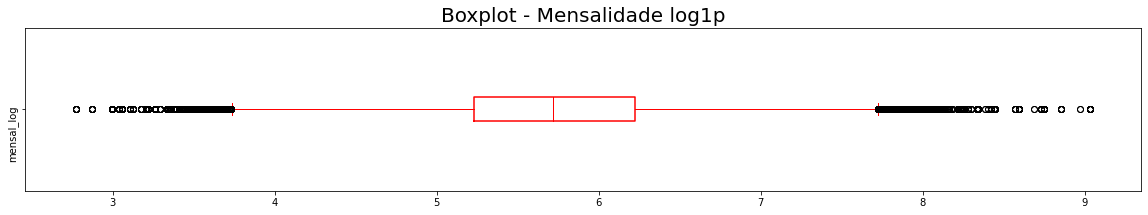

In [11]:
boxprops = dict(linestyle='-', linewidth=1.5, color = 'r')
df_copia.boxplot(column=['mensal_log'], 
                vert=False, 
                grid=False,
                showfliers=True, 
                rot=90, 
                fontsize=10, 
                figsize=(20,3),
                color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                boxprops=boxprops).set_title("Boxplot - Mensalidade log1p", fontsize=20)

In [9]:
df_copia = df_copia[df_copia['mensal_log'].between(3.5, 8.0, inclusive=True)]

In [10]:
df_copia.shape

(1212624, 12)

Text(0.5, 1.0, 'Boxplot - Mensalidade log1p')

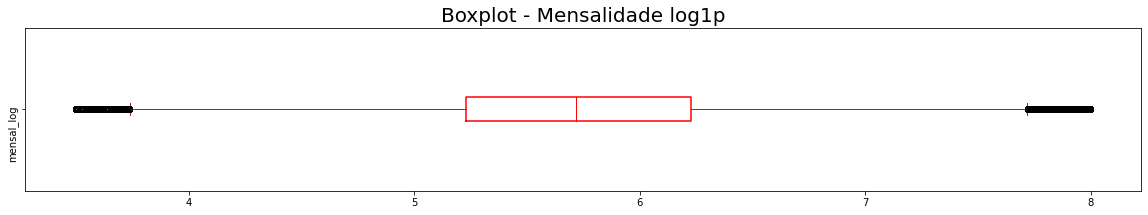

In [14]:
boxprops = dict(linestyle='-', linewidth=1.5, color = 'r')
df_copia.boxplot(column=['mensal_log'], 
                vert=False, 
                grid=False,
                showfliers=True, 
                rot=90, 
                fontsize=10, 
                figsize=(20,3),
                color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                boxprops=boxprops).set_title("Boxplot - Mensalidade log1p", fontsize=20)

#### Criação de uma versão normalizada dos dados (df_v1)

In [11]:
# Criação de várias versões dos dados originais
# Versão: 1
df_v1 = df_copia.copy()

In [12]:
# Criação dos encoders
encoders = dict()
for col in df_v1.columns[:-1]:
    le = LabelEncoder()

    # Aplica o encoder nas variáveis que estão com string
    df_v1[col] = le.fit_transform(df_v1[col])
    
    # Inclui o encoder no dicionário para posterior uso
    encoders[col]=le.classes_

# Remove valores missing eventualmente gerados
df_v1.dropna(inplace = True)

In [13]:
encoders

{'abrangencia': array(['Estadual', 'Grupo de estados', 'Grupo de municípios', 'Municipal',
        'Nacional'], dtype=object),
 'acomodacao': array(['Coletiva', 'Individual', 'Não se aplica'], dtype=object),
 'ano_mes': array(['2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
        '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
        '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
        '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
        '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
        '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
        '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
        '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
        '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
        '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07'],
       dtype=object),
 'cd_faixa_etaria'

In [ ]:
# Salvando os índices dos valores categóricos para uso futuro (encoders)
joblib.dump(encoders, '../model/encoders.bin', compress=True)

['../model/encoders.bin']

#### Criação de uma versão com dummy drop_first = True dos dados (df_v2)

In [14]:
# Criação de várias versões dos dados originais
# Versão: 2
df_v2 = df_copia.copy()
df_v2[['ano', 'mes']] = df_v2['ano_mes'].str.split('-', 1, expand=True)
del df_v2['ano_mes']

In [15]:
df_v2_categorias = df_v2[[col for col in list(df_v2) if col not in ['mensalidade', 'mensal_log']]]
df_v2_mensalidade = df_v2['mensalidade']
df_v2_mensal_log = df_v2['mensal_log']
df_v2 = pd.get_dummies(data=df_v2_categorias, columns=list(df_v2_categorias), drop_first=True)
df_v2[['mensalidade']] = df_v2_mensalidade
df_v2[['mensal_log']] = df_v2_mensal_log

In [112]:
df_v2_encoders = [col for col in list(df_v2) if col not in ['mensalidade', 'mensal_log']]

In [113]:
joblib.dump(df_v2_encoders, '/content/drive/MyDrive/Colab Notebooks/new_dataset_dummy_first_true.bin', compress=True)

['/content/drive/MyDrive/Colab Notebooks/data/new_dataset_dummy_first_encoders.bin']

In [18]:
df_v2.shape

(1212624, 47)

## Modelo preditivo SVM

### Preparando os dados de Treino e de Teste

In [21]:
# Gerando uma amostra só para testar se o restante do código funciona ...
# ------->> Comentar essa linha em "produção" <<------- #
df_v1_sample = df_v1.sample(1000)
df_v2_sample = df_v2.sample(1000)

In [25]:
# Resumo do treinamento do modelo - Iremos gerar um dicionário para cada modelo treinado, ao final podemos comparar
def write_dict_results(vs, Kernel, start, end, y_teste, previsoes):
    SVM_dict = {'Modelo':'SVM',
               'Versão':vs,
               'Kernel': Kernel,
               'Tempo Treino (min)' : round((end - start)/60,0),
               'MSE':mean_squared_error(y_teste, previsoes),
               'R2':r2_score(y_teste, previsoes),
               'MAE':mean_absolute_error(y_teste, previsoes),
               'EVS':explained_variance_score(y_teste, previsoes)}
    return SVM_dict

In [27]:
# Definindo valores que serao testados na SVR
# kernel=[‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’]

# constante de regularizacao, testar maiores e menores que o default, se der extremos, varias mais
c_range = np.array([200.,100.,50.,10.,1.0,0.95,1.05,1.1,1.2,1.5,2,0.9,0.8]) 
# só usados para kernel polinomio, para  o resto serao ignorados
polinomio_range = np.array([2,3,4,5])
epsilon_range = np.array([0.1,0.2,0.05,0.03,0.02,0.01,0.005])
gamma_range = ['scale', 'auto']
r_range =  np.array([0.5, 1])
svm_param_grid = {"C":c_range, "degree":polinomio_range, "epsilon":epsilon_range, "gamma":gamma_range, "coef0":r_range}

### Definição do modelo ``Base``

In [ ]:
# Separando X e y (variáveis explanatórias da variável alvo)
X_encoder = df_v1_sample.iloc[:, 0:10]
y_encoder_mensalidade = df_v1_sample.iloc[:, 10]

In [ ]:
# Divisão em dados de Treino e Teste.
X_treino_encoder, X_teste_encoder, y_treino_encoder, y_teste_encoder = train_test_split(X_encoder, y_encoder_mensalidade, test_size = 0.3, random_state = 69)

In [ ]:
# Padronização dos dados (atributos categóricos que foram convertidos em índices)
sc = StandardScaler()
X_treino_encoder_scaled = sc.fit_transform(X_treino_encoder)
X_teste_encoder_scaled = sc.transform(X_teste_encoder)

In [ ]:
# Salvando os valores de transformação para usar nos novos dados - escala
joblib.dump(sc, '../model/std_scaler.bin', compress=True)

['../model/std_scaler.bin']

In [ ]:
# Modelo Base
modelo_v1 = svm.SVR(kernel = 'linear')

In [ ]:
# Treinamento
start = time.time()
modelo_v1.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 0.6375508308410645


In [ ]:
# Previsões
previsoes_v1 = modelo_v1.predict(X_teste_scaled)

In [ ]:
# Dicionário de métricas e metadados
SVM_dict_v1 = write_dict_results(1, "Linear", start, end, y_teste, previsoes_v1)

In [ ]:
SVM_dict_v1

{'EVS': 0.3682047276663759,
 'Kernel': 'Linear',
 'MAE': 178.96664940453667,
 'MSE': 92677.32697286589,
 'Modelo': 'SVM',
 'R2': 0.3270476411338825,
 'Tempo Treino (min)': 0.0,
 'Versão': 1}

### GridSearchCV + Kernel RBF

In [ ]:
# Cria o modelo
modelo_v2 = svm.SVR(kernel = 'rbf')

# Grid Search com 3 validações cruzadas
start = time.time()
modelo_v2_grid_search_rbf = GridSearchCV(modelo_v2, svm_param_grid, cv = 3)

# Treinamento
modelo_v2_grid_search_rbf.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v2_grid_search_rbf.best_score_ :.2%}")
print(f"Hiperparâmetros Ideais: {modelo_v2_grid_search_rbf.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 3786.5262286663055
Acurácia em Treinamento: 44.16%
Hiperparâmetros Ideais: {'C': 200.0, 'coef0': 0.5, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto'}


In [ ]:
# Previsões
previsoes_v2 = modelo_v2_grid_search_rbf.predict(X_teste_scaled)

In [ ]:
# Dicionário de métricas e metadados
SVM_dict_v2 = write_dict_results(2, "RBF", start, end, y_teste, previsoes_v2)

### GridSearchCV + Kernel Sigmoid

In [ ]:
# Cria o modelo
modelo_v3 = svm.SVR(kernel = 'sigmoid')

# Grid Search com 3 validações cruzadas
start = time.time()
modelo_v3_grid_search_rbf = GridSearchCV(modelo_v2, svm_param_grid, cv = 3)

# Treinamento
modelo_v3_grid_search_rbf.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v2_grid_search_rbf.best_score_ :.2%}")
print(f"Hiperparâmetros Ideais: {modelo_v2_grid_search_rbf.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 3775.4246821403503
Acurácia em Treinamento: 44.16%
Hiperparâmetros Ideais: {'C': 200.0, 'coef0': 0.5, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto'}


In [ ]:
# Previsões
previsoes_v3 = modelo_v3_grid_search_rbf.predict(X_teste_scaled)

In [ ]:
# Dicionário de métricas e metadados
SVM_dict_v3 = write_dict_results(3, "Sigmoid", start, end, y_teste, previsoes_v3)

### GridSearchCV + Kernel Polinomial (SAMPLE 1000) 68.44%

In [ ]:
# Cria o modelo
modelo_v4 = svm.SVR(kernel = 'poly')

# Grid Search
start = time.time()
modelo_v4_grid_search_poly = GridSearchCV(modelo_v4, svm_param_grid, cv = 3)

# Treinamento
modelo_v4_grid_search_poly.fit(X_treino_encoder_scaled, y_treino_encoder)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v4_grid_search_poly.best_score_ :.2%}")
print(f"Hiperparâmetros Ideais: {modelo_v4_grid_search_poly.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 164.36070156097412
Acurácia em Treinamento: 58.20%
Hiperparâmetros Ideais: {'C': 100.0, 'coef0': 1.0, 'degree': 3, 'epsilon': 0.2, 'gamma': 'auto'}


In [ ]:
# Previsões
previsoes_v4 = modelo_v4_grid_search_poly.predict(X_teste_encoder_scaled)

In [ ]:
# Dicionário de métricas e metadados
SVM_dict_v4 = write_dict_results(4, "Polinomial", start, end, y_teste_encoder, previsoes_v4)

In [ ]:
SVM_dict_v4

{'EVS': 0.6851450417551521,
 'Kernel': 'Polinomial',
 'MAE': 113.69771713297038,
 'MSE': 26837.341365655127,
 'Modelo': 'SVM',
 'R2': 0.6844413760972685,
 'Tempo Treino (min)': 3.0,
 'Versão': 4}

### GridSearchCV + Kernel Polinomial  (dummy drop_first = True) (SAMPLE 1000) 56.11%

In [ ]:
# Separando X e y (variáveis explanatórias da variável alvo)
X_original = df_v2_sample[[col for col in list(df_v2_sample) if col not in ['mensalidade', 'mensal_log']]]
y_original_mensalidade = df_v2_sample['mensalidade']

In [ ]:
# Divisão em dados de Treino e Teste.
X_treino_original_com_dummy_variables, X_teste_original_com_dummy_variables, y_treino_original, y_teste_original = train_test_split(X_original, y_original_mensalidade, test_size = 0.3, random_state = 69)

In [ ]:
# Cria o modelo
modelo_v4 = svm.SVR(kernel = 'poly')

# Grid Search
start = time.time()
modelo_v4_grid_search_poly = GridSearchCV(modelo_v4, svm_param_grid, cv = 3)

# Treinamento
modelo_v4_grid_search_poly.fit(X_treino_original_com_dummy_variables, y_treino_original)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v4_grid_search_poly.best_score_ :.2%}")
print(f"Hiperparâmetros Ideais: {modelo_v4_grid_search_poly.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 173.84168767929077
Acurácia em Treinamento: 59.82%
Hiperparâmetros Ideais: {'C': 200.0, 'coef0': 1.0, 'degree': 2, 'epsilon': 0.2, 'gamma': 'scale'}


In [ ]:
# Previsões
previsoes_v4 = modelo_v4_grid_search_poly.predict(X_teste_original_com_dummy_variables)

In [ ]:
# Dicionário de métricas e metadados
SVM_dict_v4 = write_dict_results(4, "Polinomial", start, end, y_teste_original, previsoes_v4)

In [ ]:
SVM_dict_v4

{'EVS': 0.573904851144017,
 'Kernel': 'Polinomial',
 'MAE': 132.52129120561943,
 'MSE': 51341.175136153775,
 'Modelo': 'SVM',
 'R2': 0.5611967632286252,
 'Tempo Treino (min)': 3.0,
 'Versão': 4}

## Modelo preditivo MLP Regressor

In [117]:
# Resumo do treinamento do modelo - Iremos gerar um dicionário para cada modelo treinado, ao final podemos comparar
def write_mlp_dict_results(vs, start, end, y_teste, previsoes):
    model_dict = {'Modelo':'MLPRegressor',
               'Versão':vs,
               'Tempo Treino (min)' : round((end - start)/60,0),
               'MSE':mean_squared_error(y_teste, previsoes),
               'R2':r2_score(y_teste, previsoes),
               'MAE':mean_absolute_error(y_teste, previsoes),
               'EVS':explained_variance_score(y_teste, previsoes)}
    return model_dict

### MLPRegressor (dummy drop_first = True c/ log) (FULL DATASET - 4min) 81.05%

In [119]:
# Separando X e y (variáveis explanatórias da variável alvo)
X_original = df_v2[[col for col in list(df_v2) if col not in ['mensalidade', 'mensal_log']]]
y_original_mensal_log = df_v2['mensal_log']
# Divisão em dados de Treino e Teste.
X_treino_original_com_dummy_variables, X_teste_original_com_dummy_variables, y_treino_original, y_teste_original = train_test_split(X_original, y_original_mensal_log, test_size = 0.3, random_state = 69)

In [36]:
mlp_model = MLPRegressor(hidden_layer_sizes=(30,30,30))

start = time.time()
mlp_model.fit(X_treino_original_com_dummy_variables, y_treino_original)
end = time.time()
print('Tempo Treino (min) :' + str(round((end - start)/60,0)))

Tempo Treino (min) :4.0


In [37]:
print(f"Acurácia em Treinamento: {mlp_model.score(X_teste_original_com_dummy_variables, y_teste_original) :.2%}")

Acurácia em Treinamento: 81.05%


In [121]:
# Previsões
previsoes_v1 = mlp_model.predict(X_teste_original_com_dummy_variables)
# Dicionário de métricas e metadados
MLP_dict_v1 = write_mlp_dict_results(1, start, end, y_teste_original, previsoes_v1)
MLP_dict_v1

{'EVS': 0.8113122445926482,
 'MAE': 0.2398838359775528,
 'MSE': 0.09941024339805464,
 'Modelo': 'MLPRegressor',
 'R2': 0.8104976383843623,
 'Tempo Treino (min)': 4.0,
 'Versão': 1}

In [38]:
# Salvando o moddelo
with open('/content/drive/MyDrive/Colab Notebooks/models/mlpregressor_v1.pickle', 'wb') as f:
  pickle.dump(mlp_model, f)

### MLPRegressor (dados normalizados c/ log) (FULL DATASET - 4min) 80.69%

In [153]:
# Separando X e y (variáveis explanatórias da variável alvo)
X_encoder = df_v1.iloc[:, 0:10]
y_encoder_mensalidade = df_v1.iloc[:, 11]

# Divisão em dados de Treino e Teste.
X_treino_encoder, X_teste_encoder, y_treino_encoder, y_teste_encoder = train_test_split(X_encoder, y_encoder_mensalidade, test_size = 0.3, random_state = 69)
# Padronização dos dados (atributos categóricos que foram convertidos em índices)
sc = StandardScaler()
X_treino_encoder_scaled = sc.fit_transform(X_treino_encoder)
X_teste_encoder_scaled = sc.transform(X_teste_encoder)

In [47]:
mlp_model = MLPRegressor(hidden_layer_sizes=(30,30,30))

start = time.time()
mlp_model.fit(X_treino_encoder_scaled, y_treino_encoder)
end = time.time()
print('Tempo Treino (min) :' + str(round((end - start)/60,0)))

Tempo Treino (min) :4.0


In [48]:
print(f"Acurácia em Treinamento: {mlp_model.score(X_teste_encoder_scaled, y_teste_encoder) :.2%}")

Acurácia em Treinamento: 80.69%


In [123]:
# Previsões
previsoes_v2 = mlp_model.predict(X_teste_encoder_scaled)
# Dicionário de métricas e metadados
MLP_dict_v2 = write_mlp_dict_results(2, start, end, y_teste_encoder, previsoes_v2)
MLP_dict_v2

{'EVS': 0.8080310132938611,
 'MAE': 0.24173964574541254,
 'MSE': 0.10129073548899421,
 'Modelo': 'MLPRegressor',
 'R2': 0.8069129203507723,
 'Tempo Treino (min)': 4.0,
 'Versão': 2}

In [154]:
# Salvando o moddelo
with open('/content/drive/MyDrive/Colab Notebooks/models/mlpregressor_v2.pickle', 'wb') as f:
  pickle.dump(mlp_model, f)

# Salvando a normalização
with open('/content/drive/MyDrive/Colab Notebooks/mlpregressor_v2_sc.pickle', 'wb') as f:
  pickle.dump(sc, f)

### MLPRegressor (dados normalizados) (FULL DATASET - 25min) 80.18%

In [160]:
# Separando X e y (variáveis explanatórias da variável alvo)
X_encoder = df_v1.iloc[:, 0:10]
y_encoder_mensalidade = df_v1.iloc[:, 10]

# Divisão em dados de Treino e Teste.
X_treino_encoder, X_teste_encoder, y_treino_encoder, y_teste_encoder = train_test_split(X_encoder, y_encoder_mensalidade, test_size = 0.3, random_state = 69)
# Padronização dos dados (atributos categóricos que foram convertidos em índices)
sc = StandardScaler()
X_treino_encoder_scaled = sc.fit_transform(X_treino_encoder)
X_teste_encoder_scaled = sc.transform(X_teste_encoder)

In [161]:
mlp_model = MLPRegressor(hidden_layer_sizes=(30,30,30))

start = time.time()
mlp_model.fit(X_treino_encoder_scaled, y_treino_encoder)
end = time.time()
print('Tempo Treino (min) :' + str(round((end - start)/60,0)))

Tempo Treino (min) :25.0


In [162]:
print(f"Acurácia em Treinamento: {mlp_model.score(X_teste_encoder_scaled, y_teste_encoder) :.2%}")

Acurácia em Treinamento: 80.18%


In [163]:
# Previsões
previsoes_v4 = mlp_model.predict(X_teste_encoder_scaled)
# Dicionário de métricas e metadados
MLP_dict_v4 = write_mlp_dict_results(4, start, end, y_teste_encoder, previsoes_v4)
MLP_dict_v4

{'EVS': 0.8019797099944047,
 'MAE': 4625.093565320873,
 'MSE': 38098804.54415358,
 'Modelo': 'MLPRegressor',
 'R2': 0.8018134681799167,
 'Tempo Treino (min)': 25.0,
 'Versão': 4}

In [164]:
# Salvando o moddelo
with open('/content/drive/MyDrive/Colab Notebooks/models/mlpregressor_v4.pickle', 'wb') as f:
  pickle.dump(mlp_model, f)

# Salvando a normalização
with open('/content/drive/MyDrive/Colab Notebooks/models/mlpregressor_v4_sc.pickle', 'wb') as f:
  pickle.dump(sc, f)

### MLPRegressor (dummy drop_first = True) (FULL DATASET - 40min) 77.30%

In [124]:
# Separando X e y (variáveis explanatórias da variável alvo)
X_original = df_v2[[col for col in list(df_v2) if col not in ['mensalidade', 'mensal_log']]]
y_original_mensalidade = df_v2['mensalidade']
# Divisão em dados de Treino e Teste.
X_treino_original_com_dummy_variables, X_teste_original_com_dummy_variables, y_treino_original, y_teste_original = train_test_split(X_original, y_original_mensalidade, test_size = 0.3, random_state = 69)

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes=(30,30,30))

start = time.time()
mlp_model.fit(X_treino_original_com_dummy_variables, y_treino_original)
end = time.time()
print('Tempo Treino (min) :' + str(round((end - start)/60,0)))

Tempo de Treinamento do Modelo MLPRegressor: 2296.196437597275


In [ ]:
print(f"Acurácia em Treinamento: {mlp_model.score(X_teste_original_com_dummy_variables, y_teste_original) :.2%}")

Acurácia em Treinamento: 77.30%


In [126]:
# Previsões
previsoes_v3 = mlp_model.predict(X_teste_original_com_dummy_variables)
# Dicionário de métricas e metadados
MLP_dict_v3 = write_mlp_dict_results(3, start, end, y_teste_original, previsoes_v3)
MLP_dict_v3

{'EVS': 0.7733914248696032,
 'MAE': 96.21051802261333,
 'MSE': 24351.060777158244,
 'Modelo': 'MLPRegressor',
 'R2': 0.7730162563254109,
 'Tempo Treino (min)': 38.0,
 'Versão': 3}

In [ ]:
# Salvando o moddelo
with open('/content/drive/MyDrive/Colab Notebooks/models/mlpregressor_v3.pickle', 'wb') as f:
  pickle.dump(mlp_model, f)

## Escolha do modelo preditivo SVM e gravação do treinamento

In [ ]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'SVM_dict_v1':pd.Series(SVM_dict_v1),
                       'SVM_dict_v2':pd.Series(SVM_dict_v2),
                       'SVM_dict_v3':pd.Series(SVM_dict_v3),
                       'SVM_dict_v4':pd.Series(SVM_dict_v4)})

In [ ]:
# Salvando os resultados
resumo.to_csv('../model/resumo_treinos.cvs')

In [ ]:
resumo.T

,Modelo,Versão,Kernel,Tempo Treino (min),MSE,R2,MAE,EVS
SVM_dict_v1,SVM,1,Linear,0.0,96608.95756,0.316049,183.719888,0.355357
SVM_dict_v2,SVM,2,RBF,63.0,71475.165832,0.493986,149.176883,0.515438
SVM_dict_v3,SVM,3,Sigmoid,63.0,71475.165832,0.493986,149.176883,0.515438
SVM_dict_v4,SVM,4,Polinomial,70.0,67655.560937,0.521027,146.504438,0.537713


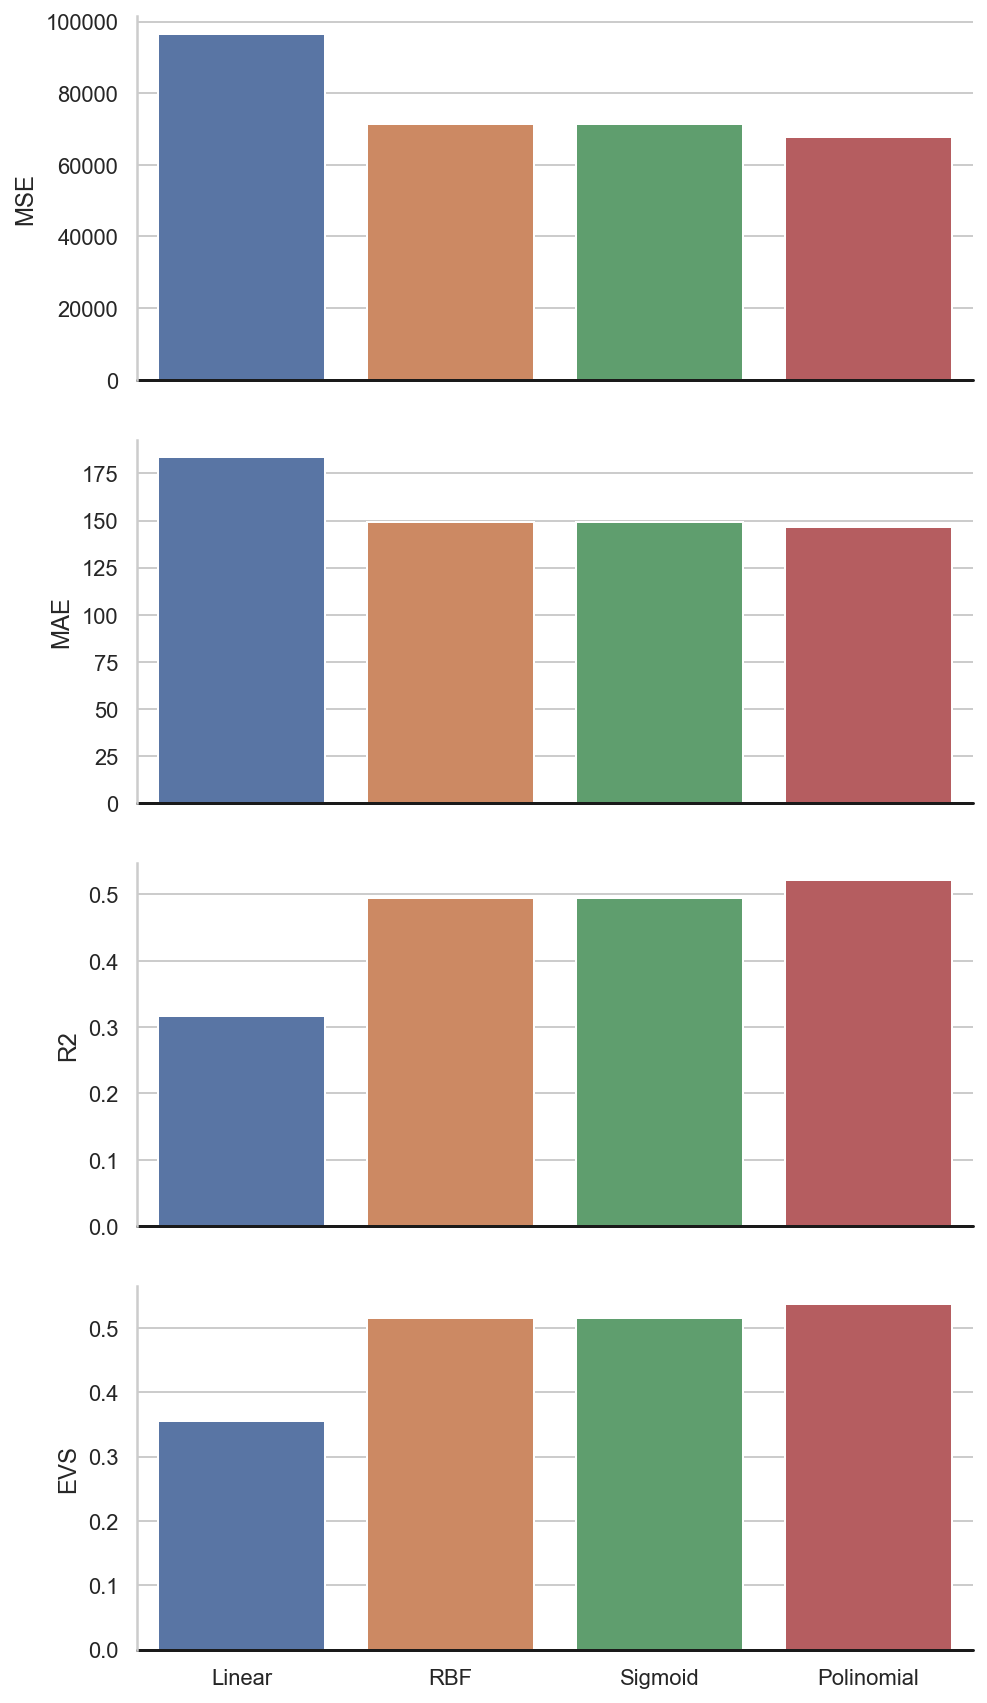

In [ ]:
# Comparação dos resultados de maneira gráfica
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(7, 12), sharex=True)

x=np.array(resumo.T['Kernel'])

sns.barplot(x=x, y=resumo.T['MSE'], palette="deep", orient = 'v', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("MSE")

sns.barplot(x=x, y=resumo.T['MAE'], palette="deep", orient = 'v', ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("MAE")

sns.barplot(x=x, y=resumo.T['R2'], palette="deep", orient = 'v', ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("R2")

sns.barplot(x=x, y=resumo.T['EVS'], palette="deep",orient = 'v',  ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("EVS")

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [ ]:
# Salvando os modelos de previsão
joblib.dump(modelo_v1, '../model/svm_linear_v1.bin', compress=True)
joblib.dump(modelo_v2_grid_search_rbf, '../model/svm_rbf_v2.bin', compress=True)
joblib.dump(modelo_v3_grid_search_rbf, '../model/svm_sigmoid_v3.bin', compress=True)
joblib.dump(modelo_v4_grid_search_poly, '../model/svm_poly_v4.bin', compress=True)

['../model/svm_poly_v4.bin']

## Escolha do modelo preditivo MLP Regressor e gravação do treinamento

In [165]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'MLP_dict_v1':pd.Series(MLP_dict_v1),
                       'MLP_dict_v2':pd.Series(MLP_dict_v2),
                       'MLP_dict_v3':pd.Series(MLP_dict_v3),
                       'MLP_dict_v4':pd.Series(MLP_dict_v4)})

In [166]:
# Salvando os resultados
resumo.to_csv('/content/drive/MyDrive/Colab Notebooks/resumo_mlp_treinos.csv')

In [167]:
resumo.T

,Modelo,Versão,Tempo Treino (min),MSE,R2,MAE,EVS
MLP_dict_v1,MLPRegressor,1,4,0.0994102,0.810498,0.239884,0.811312
MLP_dict_v2,MLPRegressor,2,4,0.101291,0.806913,0.24174,0.808031
MLP_dict_v3,MLPRegressor,3,38,24351.1,0.773016,96.2105,0.773391
MLP_dict_v4,MLPRegressor,4,25,3.80988e+07,0.801813,4625.09,0.80198


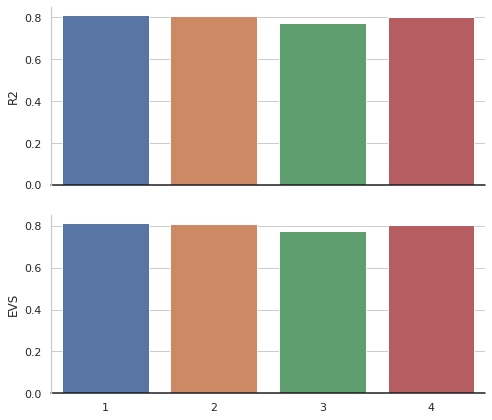

In [175]:
# Comparação dos resultados de maneira gráfica
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7, 6), sharex=True)

x=np.array(resumo.T['Versão'])

sns.barplot(x=x, y=resumo.T['R2'], palette="deep", orient = 'v', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("R2")

sns.barplot(x=x, y=resumo.T['EVS'], palette="deep",orient = 'v',  ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("EVS")

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

---

## Utilização do modelo para novas previsões

- Devemos utilizar o ``encode``, isto é, a conversão dos índices dos valores categóricos em numéricos. No início do Jupyter salvamos esse dicionário onde a chave representa no nome da variável explanatória e o valor (do dicionário) é um array com os possíveis valores observados na massa de dados para esse atributo;
- Além do _encode_ precisamos aplicar a escala aos dados, isto é a função ``StandardScaler()`` registrada e gradava no objeto ``sc`` que foi utilizada para os dados de treino do modelo (o modelo foi treinado com uma escada diferente da apresentada pelos índices do encode por questões de melhoria de performance do modelo SVM)
- Por fim, devemos apresentar ao modelo o novo dado no mesmo formato do dado utilizado durante o treinamento

### Para o modelo normalizado (df_v1)

In [ ]:
# Recuperando o encoder utilizado no pré-processamento dos dados
encoders=joblib.load('../model/encoders.bin')

In [ ]:
encoders

{'ano_mes': array(['2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
        '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
        '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
        '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
        '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
        '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
        '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
        '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
        '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
        '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07'],
       dtype=object),
 'contratacao': array(['Coletivo por adesão', 'Individual ou familiar'], dtype=object),
 'segmentacao': array(['Ambulatorial', 'Ambulatorial e Hospitalar', 'Hospitalar'],
       dtype=object),
 'in_odonto': array([0, 1], dtype

In [ ]:
sample = [encoders['ano_mes'][58], encoders['contratacao'][1], encoders['segmentacao'][1], encoders['in_odonto'][0], 
          encoders['in_obstetricia'][1], encoders['abrangencia'][2], encoders['fator'][1], encoders['acomodacao'][1],
          encoders['internacao'][1], encoders['cd_faixa_etaria'][7], encoders['nm_regiao'][3]]

In [ ]:
sample

['2020-06',
 'Individual ou familiar',
 'Ambulatorial e Hospitalar',
 0,
 1,
 'Grupo de municípios',
 'Co-participação',
 'Individual',
 'Parcial com internação',
 8,
 'Sudeste']

In [ ]:
[encoders[k].tolist().index(v) for k, v in zip(encoders.keys(), sample)]

[58, 1, 1, 0, 1, 2, 1, 1, 1, 7, 3]

In [ ]:
# Recuperando a transformação de escala dos dados utilizado no treinemento
sc=joblib.load('../model/std_scaler.bin')

In [ ]:
# Geração de um novo conjunto de variáveis explanatórias para previsão da mensalidade

# List Comprehension para leitura dos índices dos encoders, com base na lista "sample"
novo_x = [encoders[k].tolist().index(v) for k, v in zip(encoders.keys(), sample)]

# Transformação de dimensão desse array gerado (devemos apresentar o mesmo formato ao modelo)
novo_x = np.array(novo_x).reshape(1, -1)

# Aplicação da escala aos dados "novos" com base nos valores de conversão para os dados de treino
novo_x_scaled = sc.transform(novo_x)

In [ ]:
# Array que deve ser apresentado ao modelo
novo_x_scaled

array([[ 0.97676461,  1.34498653,  0.05933101, -0.16703337,  0.33121287,
        -0.48883928,  0.34774244,  0.60015966,  1.64301919,  0.86856931,
         0.41029804]])

In [ ]:
# Recuperando o modelo salvo
modelo = joblib.load('../model/svm_sigmoid_v3.bin')

In [ ]:
# previsões da mensalidade com base nos dados
previsao_novo_x = modelo.predict(novo_x_scaled)
np.round(previsao_novo_x,2)[0]

600.92

### Para o modelo c/ dummy drop_first = True (df_v2 c/ log)

In [195]:
def how_much_dummy_drop_first_true_and_log(sample):
  # Lê encoders
  encoders = joblib.load('/content/drive/MyDrive/Colab Notebooks/new_dataset_dummy_first_true_encoders.bin')
  
  # Prepara novo sample
  novo_sample = pd.DataFrame()
  for col in encoders:
    novo_sample[col] = [0]

  for col in sample.columns:
    new_col = col + '_' + str(sample.iloc[0][col])
    if new_col in novo_sample:
      novo_sample[[new_col]] = 1
  
  # Lê modelo treinado
  model = ''
  with open('/content/drive/MyDrive/Colab Notebooks/models/mlpregressor_v1.pickle', 'rb') as f:
    model = pickle.load(f)
  
  # Faz previsão
  res_log = model.predict(novo_sample)

  # Converte de log para o valor de mensalidade
  res_mensalidade = np.expm1(res_log)

  return res_mensalidade[0]

In [193]:
sample = df_original_v2.sample(1)
sample[['ano', 'mes']] = sample['ano_mes'].str.split('-', 1, expand=True)
del sample['ano_mes']
sample

,Unnamed: 0,segmentacao,in_odonto,in_obstetricia,abrangencia,fator,acomodacao,internacao,cd_faixa_etaria,nm_regiao,mensalidade,ano,mes
204764,1377133,Ambulatorial e Hospitalar,0,1,Nacional,Co-participação,Individual,Ausente,2,Norte,298.725,2020,05


In [194]:
how_much_dummy_first_true_and_log(sample)

256.57870064735886

### Tabela de Código da faixa etária

*	(01) 00 (zero) a 18 (dezoito) anos;
*	(02) 19 (dezenove) a 23 (vinte e três) anos;
*	(03) 24 (vinte e quatro) a 28 (vinte e oito) anos;
*	(04) 29 (vinte e nove) a 33 (trinta e três) anos;
*	(05) 34 (trinta e quatro) a 38 (trinta e oito) anos;
*	(06) 39 (trinta e nove) a 43 (quarenta e três) anos;
*	(07) 44 (quarenta e quatro) a 48 (quarenta e oito) anos;
*	(08) 49 (quarenta e nove) a 53 (cinquenta e três) anos;
*	(09) 54 (cinquenta e quatro) a 58 (cinquenta e oito) anos;
*	(10) 59 (cinquenta e nove) anos ou “mais”.

In [ ]:
# Vamos melhorar esse sistema de previsão
def how_much (attrs):
        a = np.array([encoders[k].tolist().index(v) for k, v in zip(encoders.keys(), attrs)]).reshape(1, -1)
        a = sc.transform(a)
        val = modelo.predict(a)
        return np.round(val,2)[0]

In [ ]:
how_much(['2018-06', 'Coletivo por adesão', 'Ambulatorial', 1, 1, 'Nacional',
          'Franquia', 'Coletiva', 'Parcial com internação', 4, 'Norte'])

308.34

In [ ]:
how_much(['2020-07', 'Individual ou familiar', 'Ambulatorial', 0, 1, 'Nacional',
          'Co-participação', 'Coletiva', 'Total', 10, 'Sudeste'])

470.67

In [ ]:
how_much(['2020-07', 'Coletivo por adesão', 'Ambulatorial', 0, 1, 'Nacional',
          'Co-participação', 'Coletiva', 'Total', 10, 'Sudeste'])

436.73

In [ ]:
how_much(['2020-07', 'Coletivo por adesão', 'Ambulatorial', 0, 1, 'Estadual',
          'Co-participação', 'Coletiva', 'Total', 10, 'Nordeste'])

345.77